In [1]:
%load_ext pycodestyle_magic

In [2]:
%flake8_on

# PROJET Kaggle : Prix des logements - Problème de régression

## SOMMAIRE  <a class="anchor" id="sommaire"></a>
## [CONTEXTE DU PROJET](#1)<a class="anchor" id="sommaire"></a>
## [LES DONNEES DU PROJET](#2)<a class="anchor" id="sommaire"></a>
## [IMPORT DES LIBRAIRIES](#3)<a class="anchor" id="sommaire"></a>
## [MISSION 1: RECUPERATION ET TRAITEMENT DES DONNEES](#4)<a class="anchor" id="sommaire"></a>
### [M1-1 : Récuperation des données](#6)<a class="anchor" id="sommaire"></a>
### [M1-2 : Analyse et exploration des données ](#7)<a class="anchor" id="sommaire"></a>
## [MISSION 2: Modélisation](#9)<a class="anchor" id="sommaire"></a>
### [M2-1 : Pycaret ](#10)<a class="anchor" id="sommaire"></a>
### [M2-2 : Catboost  ](#11)<a class="anchor" id="sommaire"></a>
### [M2-3 : Differentes modèlisations  ](#12)<a class="anchor" id="sommaire"></a>
### [M2-4 : Combinaison des modèles ](#13)<a class="anchor" id="sommaire"></a>



--------------------------------------------------------

## [CONTEXTE DU PROJET](#sommaire)<a class="anchor" id="1"></a>

## [LES DONNEES DU PROJET](#sommaire)<a class="anchor" id="2"></a>

Les données proviennent de ce concours :
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
Elles sont composées de 81 colonnes et 2911 lignes

## [IMPORT DES LIBRAIRIES](#sommaire)<a class="anchor" id="3"></a>

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
import scipy.stats as ss
import nltk
import os
import re
import warnings
import lightgbm as lgb
from time import time
import pickle
from utils.functions import missing, mape, rmse
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, jaccard_score
from IPython.display import FileLinks
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import RidgeCV, LassoCV, LinearRegression
from sklearn.linear_model import ElasticNetCV, Ridge, Lasso
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from decimal import Decimal as Dec
from pandas.api.types import CategoricalDtype
from sklearn.preprocessing  import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.model_selection import KFold, cross_val_score

In [2]:
# Configuration affichage
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

## [MISSION 1: RECUPERATION ET TRAITEMENT DES DONNEES](#sommaire)<a class="anchor" id="4"></a>

### [M1-1 : Récuperation des données](#sommaire)<a class="anchor" id="6"></a>

In [3]:
# Les données d'entrainement : toutes les variables + le prix
df_train = pd.read_csv('data/train.csv',
                       sep=',', engine='python')

# Les données de test avec toutes les variables sauf le prix
df_test = pd.read_csv('data/test.csv',
                      sep=',', engine='python')

# Les prix des données dans fichier test et l'id
df_sample_submission = pd.read_csv('data/sample_submission.csv',
                                   sep=',', engine='python')

In [4]:
print('Entrainement : {} lignes et {} colonnes.'.format(df_train.shape[0],
                                                        df_train.shape[1]))
print('Test : {} lignes et {} colonnes.'.format(df_test.shape[0], df_test.shape[1]))

Entrainement : 1460 lignes et 81 colonnes.
Test : 1459 lignes et 80 colonnes.


#### Fusion des deux fichiers pour n'avoir qu'un

In [5]:
# Conservation de l'index pour identifier le df_train
train_index = df_train.index

# Jointure de la base d'apprentissage et la base de test
fusion_data_test = pd.merge(df_test, df_sample_submission,
                            how="right", left_on="Id", right_on="Id")
df = df_train.append(fusion_data_test).reset_index(drop=True)
# df = df_train.append(df_test).reset_index(drop=True)

# Suppression de la variable Id de la base "df"
df.drop("Id", axis=1, inplace=True)
print('dataframe final : {} lignes et {} colonnes.'.format(df.shape[0], df.shape[1]))

dataframe final : 2919 lignes et 80 colonnes.


### [M1-2 : Analyse et exploration des données](#sommaire)<a class="anchor" id="7"></a>

#### Répartition des prix :

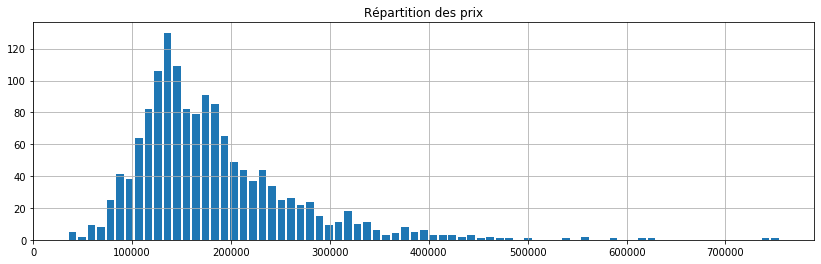

In [6]:
df_train.SalePrice.hist(bins=75, rwidth=.8, figsize=(14, 4))
plt.title('Répartition des prix')
plt.show()

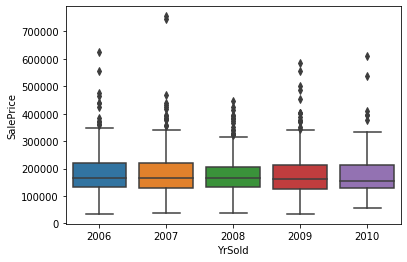

In [7]:
# Variation des prix de vente des logement selon l'année de vente
ax = sns.boxplot(x="YrSold", y="SalePrice", data=df_train)
plt.show()

#### Période de construction et de rénovation :

Text(0.5, 1.0, 'Période de construction et de rénovation ')

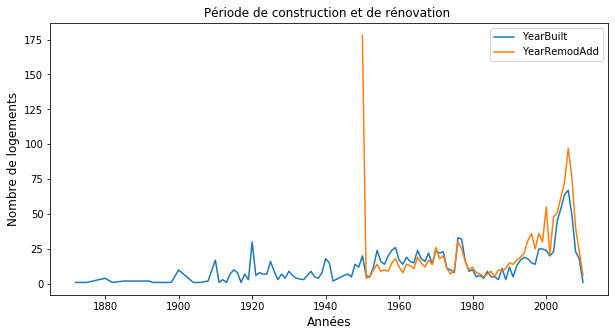

In [8]:
plt.figure(figsize=(10, 5))
# Date de construction
df_train.YearBuilt.value_counts().sort_index().plot()
plt.legend(loc='best')
# Date de Renovation
df_train.YearRemodAdd.value_counts().sort_index().plot()
plt.legend(loc='best')
plt.xlabel('Années', fontsize=12)
plt.ylabel('Nombre de logements', fontsize=12)
plt.title('Période de construction et de rénovation ')

#### Période de vente :

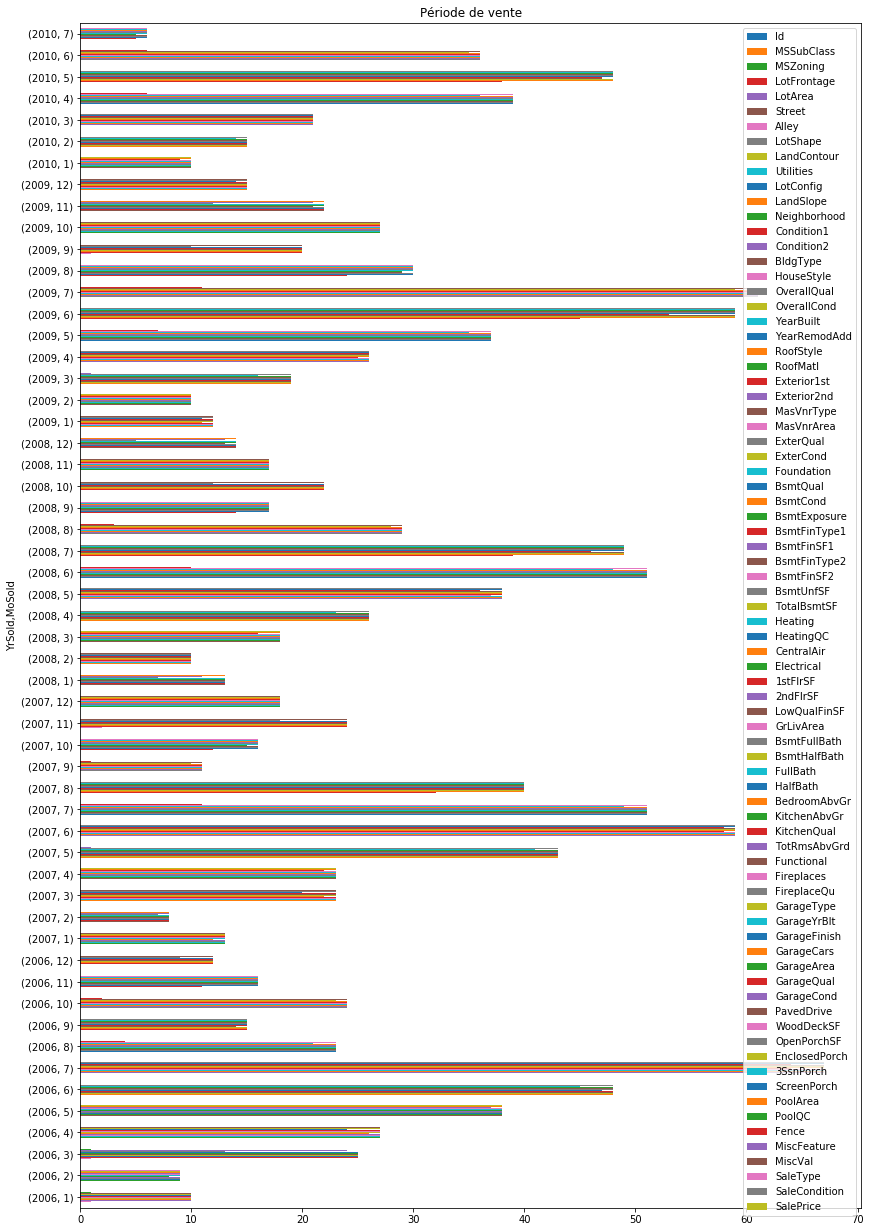

In [9]:
df_train.groupby(['YrSold', 'MoSold']).count().plot(kind='barh',
                                                    figsize=(14, 21.8))
plt.title('Période de vente')
plt.show()

#### Preprocessing : 

##### Déterminer les taux de remplissage des variables.
- Retirer les variables trop peu remplies

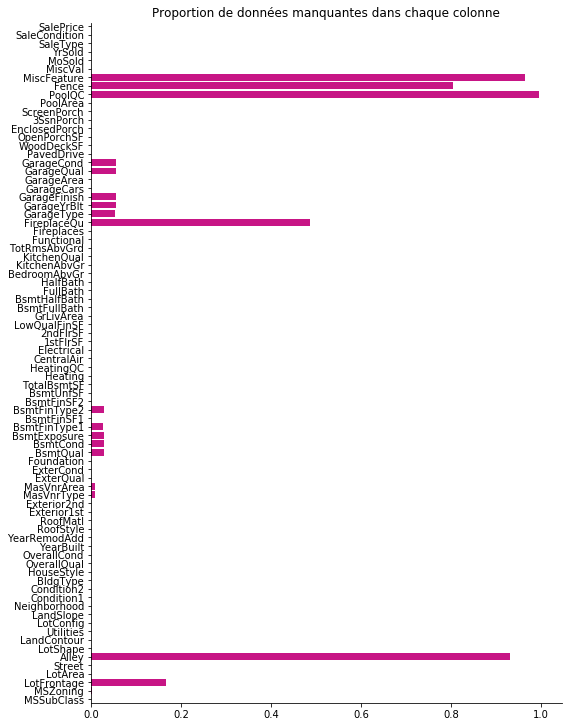

In [10]:
# Supprimer les colonnes trop peu remplies
#   La proportion de valeurs manquantes par colonne
# permettra de connaitre les colonnes à supprimer
null_counts = df.isnull().mean(axis=0)

#   barplot des valeurs manquantes par colonne
fig = plt.figure(figsize=(8, 10))
plt.barh(np.arange(len(null_counts)), null_counts, color="mediumvioletred")
plt.yticks(np.arange(len(null_counts)), null_counts.index,
           rotation=0, fontsize=10)
sns.despine()
plt.margins(y=0)
plt.tight_layout()
plt.title('Proportion de données manquantes dans chaque colonne')
plt.show()

In [11]:
# Les variables ayant plus de 40% de valeurs manquantes
colsdel = list(df.columns[df.isnull().sum() / len(df) > 0.40])
df.drop(colsdel, axis=1, inplace=True)

In [12]:
# Les colonnes supprimées car n'ont pas suffisament des données sont :
colsdel

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [13]:
# Selection des variables categorielles
categorical_cols = [cname for cname in df.columns
                    if df[cname].dtype == 'object']
print(len(categorical_cols), 'variables catégorielles = ', categorical_cols)

38 variables catégorielles =  ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [14]:
# Selection des variables numériques
numeric_cols = [cname for cname in df.columns
                if df[cname].dtype in ['int64', 'float64']]
print(len(numeric_cols), 'variables numériques = ', numeric_cols)

37 variables numériques =  ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In [15]:
# Imputation des variables quantititatives manquantes par 0
varQuant = ["GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1",
            "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath",
            "BsmtHalfBath", "MasVnrArea"]
df[varQuant] = df[varQuant].apply(lambda x: x.fillna(0), axis=1)
del varQuant
# Imputation des variables qualitatives manquantes par Absent
varQual = ["GarageType", "GarageFinish", "GarageQual", "GarageCond",
           "BsmtQual", "BsmtCond", "BsmtExposure", "BsmtFinType1",
           "BsmtFinType2", "MasVnrType", "MSSubClass"]
df[varQual] = df[varQual].apply(lambda x: x.fillna('Absent'), axis=1)
del varQual

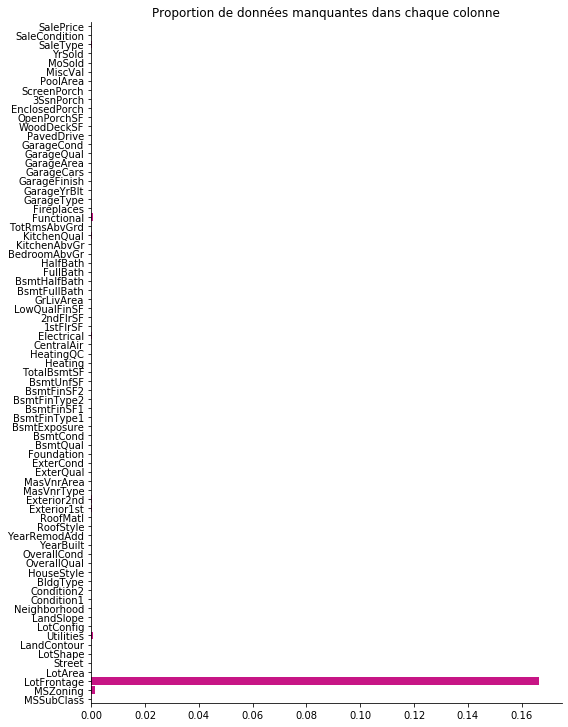

In [16]:
null_counts = df.isnull().mean(axis=0)

#   barplot des valeurs manquantes par colonne
fig = plt.figure(figsize=(8, 10))
plt.barh(np.arange(len(null_counts)), null_counts, color="mediumvioletred")
plt.yticks(np.arange(len(null_counts)), null_counts.index,
           rotation=0, fontsize=10)
sns.despine()
plt.margins(y=0)
plt.tight_layout()
plt.title('Proportion de données manquantes dans chaque colonne')
plt.show()

In [17]:
# Variables avec valeurs manquantes inexpliquées
missing(df)

,variable,valeur_NA,Pourcentage_NA,type
0,LotFrontage,486,16.65,float64
1,MSZoning,4,0.14,object
2,Utilities,2,0.07,object
3,Functional,2,0.07,object
4,Exterior1st,1,0.03,object
5,Exterior2nd,1,0.03,object
6,Electrical,1,0.03,object
7,KitchenQual,1,0.03,object
8,SaleType,1,0.03,object


- Imputation des variables qualitatives inexpliquées :

In [18]:
# Imputation par la mediane pour la variable numerique LotFrontage
df["LotFrontage"] = df.groupby("Neighborhood")[
    "LotFrontage"].transform(lambda x: x.fillna(x.median()))

- Imputation des variables categorielles :

In [19]:
# Nombre de cardinalité pour les variables manquantes :
print('cardinalité de Utilities : ', df['Utilities'].nunique())
print(pd.crosstab(df.Utilities, columns="Utilities"))
print('cardinalité de MSZoning : ', df['MSZoning'].nunique())
print(pd.crosstab(df.MSZoning, columns="MSZoning"))
print('cardinalité de Functional : ', df['Functional'].nunique())
print(pd.crosstab(df.Functional, columns="Functional"))
print('cardinalité de Exterior1st : ', df['Exterior1st'].nunique())
print(pd.crosstab(df.Exterior1st, columns="Exterior1st"))
print('cardinalité de Exterior2nd : ', df['Exterior2nd'].nunique())
print(pd.crosstab(df.Exterior2nd, columns="Exterior2nd"))
print('cardinalité de Electrical : ', df['Electrical'].nunique())
print(pd.crosstab(df.Electrical, columns="Electrical"))
print('cardinalité de KitchenQual : ', df['KitchenQual'].nunique())
print(pd.crosstab(df.KitchenQual, columns="KitchenQual"))
print('cardinalité de SaleType : ', df['SaleType'].nunique())
print(pd.crosstab(df.SaleType, columns="SaleType"))

cardinalité de Utilities :  2
col_0      Utilities
Utilities           
AllPub          2916
NoSeWa             1
cardinalité de MSZoning :  5
col_0     MSZoning
MSZoning          
C (all)         25
FV             139
RH              26
RL            2265
RM             460
cardinalité de Functional :  7
col_0       Functional
Functional            
Maj1                19
Maj2                 9
Min1                65
Min2                70
Mod                 35
Sev                  2
Typ               2717
cardinalité de Exterior1st :  15
col_0        Exterior1st
Exterior1st             
AsbShng               44
AsphShn                2
BrkComm                6
BrkFace               87
CBlock                 2
CemntBd              126
HdBoard              442
ImStucc                1
MetalSd              450
Plywood              221
Stone                  2
Stucco                43
VinylSd             1025
Wd Sdng              411
WdShing               56
cardinalité de Exterior2nd :

In [20]:
# Suppression de la variable "Utilities"
df.drop("Utilities", axis=1, inplace=True)

In [21]:
# Autres variables
df["Functional"] = df["Functional"].fillna(df["Functional"].mode()[0])
df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])
df["KitchenQual"] = df["KitchenQual"].fillna(df["KitchenQual"].mode()[0])
df["Exterior1st"] = df["Exterior1st"].fillna(df["Exterior1st"].mode()[0])
df["Exterior2nd"] = df["Exterior2nd"].fillna(df["Exterior2nd"].mode()[0])
df["SaleType"] = df["SaleType"].fillna(df["SaleType"].mode()[0])
df["MSZoning"] = df["MSZoning"].fillna(df["MSZoning"].mode()[0])

In [22]:
print("Il reste {} valeurs manquantes".format(df.isnull().sum().sum()))

Il reste 0 valeurs manquantes


#### Suppression des outliers :

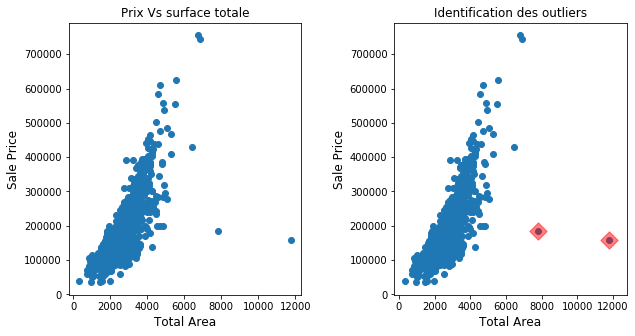

In [23]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(x=df['GrLivArea'][train_index]+df["TotalBsmtSF"][train_index],
            y=df['SalePrice'][train_index])

plt.ylabel('Sale Price', fontsize=12)
plt.xlabel('Total Area', fontsize=12)
plt.gca().set_title('Prix Vs surface totale')

plt.subplot(1, 2, 2)
plt.scatter(x=df['GrLivArea'][train_index]+df["TotalBsmtSF"][train_index],
           y=df['SalePrice'][train_index])
# Outliers : les surface supérieurs à 6 000 et prix inferieur à 300 000
df1 = df.loc[train_index, ['GrLivArea', "TotalBsmtSF", 'SalePrice']]
t = list(df1.loc[(df1['GrLivArea'] + df1["TotalBsmtSF"] > 6000)
                 & (df1['SalePrice'] < 300000)].index)

plt.scatter(df1['GrLivArea'][t[0]]+df1["TotalBsmtSF"][t[0]],
            df1['SalePrice'][t[0]], color='r', marker='D', s=150, alpha=0.5)
plt.scatter(df1['GrLivArea'][t[1]]+df1["TotalBsmtSF"][t[1]],
            df1['SalePrice'][t[1]], color='r', marker='D', s=150, alpha=0.5)

plt.ylabel('Sale Price', fontsize=12)
plt.xlabel('Total Area', fontsize=12)
plt.gca().set_title('Identification des outliers')

plt.subplots_adjust(wspace=0.4)
plt.show()

In [24]:
# Suppression des outliers
df.drop(t, axis=0, inplace=True)
train_index = [i for i in train_index if i not in t]

In [25]:
# Creation de nouvelles variables
# Age du logement (Année de vente - Année de construction)
df['AgeHouse'] = df['YrSold']-df['YearBuilt']

# Indicatrice si le logement à été rénové ou pas:
# 1 si YearBuild <> YearRemodAdd et O sinon
df['RemodHouse'] = 1*(df.YearBuilt != df.YearRemodAdd)

# Surface totale habitable du logement ( GrLivArea + TotalBsmtSF )
df["TotalArea"] = df["GrLivArea"]+df["TotalBsmtSF"]

# Ratio entre la surface habitable et la surface de la propriété
df["TotalArea"] = df["TotalArea"]/df["LotArea"]

# Ratio entre  Nbre Salles de bains / Nbre de chambres
df["BathRoomBedRoom"] = (df["FullBath"]+df["HalfBath"])/(1+df["BedroomAbvGr"])

df.drop("YearBuilt", axis=1, inplace=True)
df.drop("YearRemodAdd", axis=1, inplace=True)
df.drop("GarageYrBlt", axis=1, inplace=True)

## [MISSION 2: MODELISATION](#sommaire)<a class="anchor" id="9"></a>

#### Approche de modélisation :

#### Variables cibles : 

### [M2-1 : Pycaret ](#sommaire)<a class="anchor" id="10"></a>

In [28]:
from pycaret.datasets import get_data
from pycaret.regression import *

data = df.sample(frac=0.7).reset_index(drop=True)
print('Data for Modeling: ' + str(data.shape))

Data for Modeling: (2042, 75)


2:1: F403 'from pycaret.regression import *' used; unable to detect undefined names
8: F405 'df' may be undefined, or defined from star imports: pycaret.regression


In [30]:
reg1 = setup(data=data, target='SalePrice')

,Description,Value
0,session_id,5583
1,Target,SalePrice
2,Original Data,"(2042, 75)"
3,Missing Values,False
4,Numeric Features,24
5,Categorical Features,50
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1429, 357)"


In [31]:
compare_models(include=['lr', 'ridge', 'lasso', 'rf',
                        'gbr', 'xgboost', 'en', 'catboost'], sort='MAPE')
# les resultats sont triés par MAPE (mean_absolute_percentage_error) :
# C'est le pourcentage moyenne d'erreur en valeur absolue

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,29160.4395,1810373345.0417,42119.2877,0.4519,0.2165,0.1722,7.9720
en,Elastic Net,29641.5894,1817453061.2823,42205.7670,0.4487,0.2131,0.1727,0.6370
gbr,Gradient Boosting Regressor,29492.0783,1911616703.1639,43331.6666,0.4117,0.2190,0.1746,0.6650
rf,Random Forest Regressor,29481.5072,1880292937.6363,42959.6966,0.4268,0.2185,0.1752,2.3980
xgboost,Extreme Gradient Boosting,30614.3268,2038806553.6000,44780.8941,0.3784,0.2300,0.1811,1.5930
ridge,Ridge Regression,31332.4675,2036742356.7369,44874.5343,0.3654,0.2345,0.1852,0.0300
lasso,Lasso Regression,32965.6005,2324843935.7219,47946.8800,0.2713,0.2618,0.1957,0.5570
lr,Linear Regression,252904605.0435,5931455800202514432.0000,1996311767.4049,-1637867458.6206,1.6664,1972.1007,0.6850


In [32]:
# Mean Absolute Persentage Error
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Root Mean Squared Error
def rmse(y_pred, y_true):
    return np.sqrt(((y_pred - y_true) ** 2).mean())

catboost a le meilleur résultat

### [M2-2 : modèlisation Catboost ](#sommaire)<a class="anchor" id="11"></a>

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 2918
Data columns (total 75 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   MSSubClass       2917 non-null   int64  
 1   MSZoning         2917 non-null   object 
 2   LotFrontage      2917 non-null   float64
 3   LotArea          2917 non-null   int64  
 4   Street           2917 non-null   object 
 5   LotShape         2917 non-null   object 
 6   LandContour      2917 non-null   object 
 7   LotConfig        2917 non-null   object 
 8   LandSlope        2917 non-null   object 
 9   Neighborhood     2917 non-null   object 
 10  Condition1       2917 non-null   object 
 11  Condition2       2917 non-null   object 
 12  BldgType         2917 non-null   object 
 13  HouseStyle       2917 non-null   object 
 14  OverallQual      2917 non-null   int64  
 15  OverallCond      2917 non-null   int64  
 16  RoofStyle        2917 non-null   object 
 17  RoofMatl      

In [34]:
X = df.drop(['SalePrice'], axis=1)
y = df.SalePrice

# NB: convert y into type float
y = y.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    train_size=0.75,
                                                    random_state=42)

In [36]:
# permet de lister les variables catégorielles dans les données
categorical_features_indices = np.where(X.dtypes != np.float)[0]

In [58]:
# Model 1 : CatBoost
# Initialiser CatBoostRegressor de base
cbr = CatBoostRegressor()
parameters = {'depth': [x for x in range(5, 20 + 1, 3)],
              'learning_rate': np.arange(0.01, 0.10+0.001, 0.01),
              'iterations': [25, 50, 75],
              'loss_function': ['RMSE']}
t0 = time()
grid = GridSearchCV(estimator=cbr, param_grid=parameters, cv=2, n_jobs=-1)

grid.fit(X_train, y_train,
         cat_features=categorical_features_indices,
         eval_set=(X_test, y_test), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 57540.7863807	test: 49732.7766966	best: 49732.7766966 (0)	total: 99.1ms	remaining: 4.86s
1:	learn: 55900.4507717	test: 48246.0893664	best: 48246.0893664 (1)	total: 149ms	remaining: 3.58s
2:	learn: 54646.7437313	test: 47278.2796484	best: 47278.2796484 (2)	total: 183ms	remaining: 2.87s
3:	learn: 53257.9415365	test: 46248.2160035	best: 46248.2160035 (3)	total: 226ms	remaining: 2.6s
4:	learn: 52157.7502722	test: 45408.9774997	best: 45408.9774997 (4)	total: 273ms	remaining: 2.45s
5:	learn: 51009.1415163	test: 44668.4481718	best: 44668.4481718 (5)	total: 316ms	remaining: 2.31s
6:	learn: 49937.5863418	test: 44165.3473777	best: 44165.3473777 (6)	total: 362ms	remaining: 2.22s
7:	learn: 49009.6819955	test: 43415.9214676	best: 43415.9214676 (7)	total: 409ms	remaining: 2.15s
8:	learn: 48204.8620978	test: 43047.0093449	best: 43047.0093449 (8)	total: 454ms	remaining: 2.07s
9:	learn: 47478.8299071	test: 42571.2283997	best: 42571.2283997 (9)	total: 506ms	remaining: 2.02s
10:	learn: 46619.420

GridSearchCV(cv=2,
             estimator=<catboost.core.CatBoostRegressor object at 0x0000016DB49AC908>,
             n_jobs=-1,
             param_grid={'depth': [5, 8, 11, 14, 17, 20],
                         'iterations': [25, 50, 75],
                         'learning_rate': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                         'loss_function': ['RMSE']})

In [59]:
print('Best Params : ', grid.best_params_)
print('Best Score : ', grid.best_score_)

Best Params :  {'depth': 5, 'iterations': 50, 'learning_rate': 0.09, 'loss_function': 'RMSE'}
Best Score :  0.45548118323351583


In [37]:
# Instantiztion du modèle CatBoost
model_catboost = CatBoostRegressor(iterations=50,
                                   learning_rate=0.090,
                                   depth=5,
                                   loss_function='RMSE')

# train the model
model_catboost.fit(X_train,
                   y_train,
                   cat_features=categorical_features_indices,
                   eval_set=(X_test, y_test),
                   plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 57540.7863807	test: 49732.7766966	best: 49732.7766966 (0)	total: 48ms	remaining: 2.35s
1:	learn: 55900.4507717	test: 48246.0893664	best: 48246.0893664 (1)	total: 85.6ms	remaining: 2.05s
2:	learn: 54646.7437313	test: 47278.2796484	best: 47278.2796484 (2)	total: 114ms	remaining: 1.79s
3:	learn: 53257.9415365	test: 46248.2160035	best: 46248.2160035 (3)	total: 151ms	remaining: 1.74s
4:	learn: 52157.7502722	test: 45408.9774997	best: 45408.9774997 (4)	total: 195ms	remaining: 1.76s
5:	learn: 51009.1415163	test: 44668.4481718	best: 44668.4481718 (5)	total: 233ms	remaining: 1.71s
6:	learn: 49937.5863418	test: 44165.3473777	best: 44165.3473777 (6)	total: 272ms	remaining: 1.67s
7:	learn: 49009.6819955	test: 43415.9214676	best: 43415.9214676 (7)	total: 310ms	remaining: 1.63s
8:	learn: 48204.8620978	test: 43047.0093449	best: 43047.0093449 (8)	total: 348ms	remaining: 1.58s
9:	learn: 47478.8299071	test: 42571.2283997	best: 42571.2283997 (9)	total: 390ms	remaining: 1.56s
10:	learn: 46619.420

In [62]:
from sklearn.metrics import r2_score

# make the prediction using the resulting model
y_pred = model_catboost.predict(X_test)
r2_score(y_test, y_pred)

NameError: name 'model_catboost' is not defined

### [M2-3 : Différentes modèlisations ](#sommaire)<a class="anchor" id="12"></a>

### Préparation des variables catégorielles

In [26]:
# variable cible = y_train
df_copy = df.copy()
y_train = df_copy.SalePrice[train_index]
df_copy.drop("SalePrice", axis=1, inplace=True)

# Labelisation des variables catégorielles ordonnées
# variables ayant pour echelle d'appréciation Ex,Gd,Ta,Fa,Po,Absent
var = ["BsmtQual", "BsmtCond", "GarageQual",
       "GarageCond", "ExterQual", "ExterCond",
       "HeatingQC", "KitchenQual"]

df_copy[var] = df_copy[var].apply(lambda x: x.astype(CategoricalDtype(
    categories=["Absent", "Po", "Fa", "Ta", "Gd", "Ex"],
    ordered=True)).cat.codes, axis=1)

In [27]:
# Autres variables
var = ["BsmtFinType1", "BsmtFinType2"]
df_copy[var] = df_copy[var].apply(lambda x: x.astype(CategoricalDtype(
    categories=["Absent", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ordered=True)).cat.codes, axis=1)

df_copy['GarageFinish'] = df_copy['GarageFinish'].astype(CategoricalDtype(
    categories=["Absent", "Unf", "RFn", "Fin"], ordered=True)).cat.codes

df_copy['BsmtExposure'] = df_copy['BsmtExposure'].astype(CategoricalDtype(
    categories=["Absent", "No", "Mn", "Av", "Gd"], ordered=True)).cat.codes

df_copy['LandSlope'] = df_copy['LandSlope'].astype(CategoricalDtype(
    categories=["Gtl", "Mod", "Sev"], ordered=True)).cat.codes

df_copy = df_copy.replace({'C (all)': 'Absent'})

df_copy.drop('Condition2', axis=1, inplace=True)

#### Encodage des variables catégorielles avec One-hot encoding

In [28]:
# Variables de type numérique et categoriel ordonnés recodés
var = ['1stFlrSF', '2ndFlrSF', '3SsnPorch',
       'BedroomAbvGr', 'BsmtFullBath',
       'BsmtHalfBath', 'BsmtUnfSF', 'EnclosedPorch',
       'Fireplaces', 'FullBath', 'BsmtFinSF1',
       'GarageArea', 'GarageCars', 'GrLivArea',
       'HalfBath', 'KitchenAbvGr', 'BsmtFinSF2',
       'LotArea', 'LotFrontage', 'LowQualFinSF',
       'MasVnrArea', 'MiscVal', 'OpenPorchSF',
       'PoolArea', 'SalePrice', 'ScreenPorch', 'TotRmsAbvGrd',
       'TotalBsmtSF', 'WoodDeckSF', 'AgeHouse',
       'RemodHouse', 'BsmtQual',
       'BsmtCond', 'GarageQual', 'GarageCond',
       'ExterQual', 'ExterCond', 'HeatingQC',
       'KitchenQual', 'BsmtFinType1',
       'BsmtFinType2', 'GarageFinish', 'OverallCond',
       'MSSubClass', 'OverallQual', 'TotalArea',
       'BathRoomBedRoom', 'whisker']

# Transformation des variables non numériques en objet
nonVar = list(set(df_copy.columns).difference(set(var)))
df_copy[nonVar] = df_copy[nonVar].apply(lambda x: x.astype(str))

df_catboost = df_copy.copy()
# Nous allons tranformer toutes les autres variables en dummies
df_copy = pd.get_dummies(df_copy, columns=nonVar, sparse=True)
del var, nonVar

In [29]:
print(len(df_catboost.columns),
      ' colonnes et après One-hot encoding devient',
      len(df_copy.columns), 'colonnes')

73  colonnes et après One-hot encoding devient 238 colonnes


#### Repartition des données d'apprentissage et test :

In [30]:
# Données necesssaires à la modélisation directe

# POur les modeles nécéssitants de transfo des variables categorielles :
# Echantillon d'apprentissage, échantillon de validatin (train, valid sets)
df_train = df_copy.loc[train_index, ]

df_train, df_valid, y_train, y_valid = train_test_split(df_train,
                                                        y_train,
                                                        test_size=0.30)

# Echantillon test
df_test = df_copy.loc[[i for i in df_copy.index.tolist()
                       if i not in train_index], ]


In [31]:
# fixe random seed for reproducibility
seed = 2021
np.random.seed(seed)
n_folds = 5


# methode pour calcul score de cross-validation(valid Root Mean Squared Error)
def rmse_cv(model):
    kf = KFold(n_folds, shuffle=True,
               random_state=seed).get_n_splits(df_train.values)
    rmse = np.sqrt(- cross_val_score(model, df_train.values,
                                     y_train, scoring="neg_mean_squared_error",
                                     cv=kf))
    return(rmse)


# methode pour calcul score de cross-validation(Mean Absolute Percentage Error)
def mape_cv(model):
    kf = KFold(n_folds, shuffle=True,
               random_state=seed).get_n_splits(df_train.values)
    MAPE = np.abs(cross_val_score(model,
                                  df_train.values,
                                  y_train,
                                  scoring=make_scorer(
                                      mape,
                                      greater_is_better=False),
                                  cv=kf))
    return(MAPE)


# methode pour calculer le score de cross-validation (R2)
def r2_cv(model):
    kf = KFold(n_folds, shuffle=True,
               random_state=seed).get_n_splits(df_train.values)
    r2 = cross_val_score(model,
                         df_train.values, y_train,
                         scoring="r2", cv=kf)
    return(r2)

### Parametrage des modèles :

In [32]:
# Model 1: LinearRegression
regr = LinearRegression()
rmse_lm = rmse_cv(regr)
mape_lm = mape_cv(regr)
r2_lm = r2_cv(regr)

print('Linear Regression RMSE: {:.3f} ({:.3f})'.format(rmse_lm.mean(),
                                                       rmse_lm.std()))
print('Linear Regression MAPE: {:.2f} ({:.2f})'.format(mape_lm.mean(),
                                                       mape_lm.std()))
print('Linear Regression R2: {:.2f} ({:.2f})'.format(r2_lm.mean(), r2_lm.std()))

Linear Regression RMSE: 28910.529 (2134.074)
Linear Regression MAPE: 12.25 (0.39)
Linear Regression R2: 0.86 (0.01)


In [33]:
# Model 2: Ridge
params = {'alpha': [25, 20, 15, 12, 10, 8, 6, 5, 4, 3,
                    2, 1.0, 0.8, 0.5, 0.3, 0.2, 0.1,
                    0.05, 0.02, 0.01]}

ridge = GridSearchCV(Ridge(), params)

rmse_rdge = rmse_cv(ridge)
mape_rdge = mape_cv(ridge)
r2_rdge = r2_cv(ridge)

print('Ridge Regression RMSE: {:.3f} ({:.3f})'.format(rmse_rdge.mean(),
                                                      rmse_rdge.std()))
print('Ridge Regression MAPE: {:.2f} ({:.2f})'.format(mape_rdge.mean(),
                                                      mape_rdge.std()))
print('Ridge Regression R2: {:.2f} ({:.2f})'.format(r2_rdge.mean(),
                                                    r2_rdge.std()))

Ridge Regression RMSE: 26523.224 (2708.748)
Ridge Regression MAPE: 10.99 (0.51)
Ridge Regression R2: 0.89 (0.01)


In [34]:
# Model 3: LassoCV
ls = LassoCV(eps=0.001, n_alphas=1000, alphas=None,
             fit_intercept=True, normalize=True,
             precompute='auto', max_iter=1000,
             tol=0.0001, copy_X=True, cv=None,
             verbose=False, n_jobs=1, positive=False,
             random_state=None, selection='cyclic')

rmse_ls = rmse_cv(ls)
mape_ls = mape_cv(ls)
r2_ls = r2_cv(ls)

print('Lasso Regression RMSE: {:.3f} ({:.3f})'.format(rmse_ls.mean(),
                                                      rmse_ls.std()))
print('Lasso Regression MAPE: {:.2f} ({:.2f})'.format(mape_ls.mean(),
                                                      mape_ls.std()))
print('Lasso Regression R2: {:.2f} ({:.2f})'.format(r2_ls.mean(),
                                                    r2_ls.std()))

Lasso Regression RMSE: 26758.750 (2859.373)
Lasso Regression MAPE: 10.53 (0.64)
Lasso Regression R2: 0.88 (0.01)


In [35]:
# Model 4: RandomForestRegressor
rf = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=10,
                           min_samples_split=10, min_weight_fraction_leaf=0.0,
                           max_features='auto', max_leaf_nodes=None,
                           bootstrap=True, oob_score=False, n_jobs=-1,
                           random_state=None, verbose=0, warm_start=False)
rmse_rf = rmse_cv(rf)
mape_rf = mape_cv(rf)
r2_rf = r2_cv(rf)

print('Random Forest Regression RMSE: {:.3f} ({:.3f})'.format(rmse_rf.mean(),
                                                              rmse_rf.std()))
print('Random Forest Regression MAPE: {:.2f} ({:.2f})'.format(mape_rf.mean(),
                                                              mape_rf.std()))
print('Random Forest Regression R2: {:.2f} ({:.2f})'.format(r2_rf.mean(),
                                                            r2_rf.std()))

Random Forest Regression RMSE: 27625.787 (4612.795)
Random Forest Regression MAPE: 10.42 (0.74)
Random Forest Regression R2: 0.88 (0.03)


In [36]:
# Modèl 5 : GradientBoosting
gb = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                               max_depth=5, max_features='sqrt',
                               min_samples_split=20, loss='huber',
                               random_state=5)
rmse_gb = rmse_cv(gb)
mape_gb = mape_cv(gb)
r2_gb = r2_cv(gb)

print('Gradient Boosting Reg RMSE: {:.3f} ({:.3f})'.format(rmse_gb.mean(),
                                                           rmse_gb.std()))
print('Gradient Boosting Reg MAPE: {:.2f} ({:.2f})'.format(mape_gb.mean(),
                                                           mape_gb.std()))
print('Gradient Boosting Reg R2: {:.2f} ({:.2f})'.format(r2_gb.mean(),
                                                         r2_gb.std()))

Gradient Boosting Reg RMSE: 24121.118 (2747.686)
Gradient Boosting Reg MAPE: 8.87 (0.75)
Gradient Boosting Reg R2: 0.90 (0.01)


In [37]:
# Model 6 : Xgboosting
one_to_left = ss.beta(10, 1)
from_zero_positive = ss.expon(0, 50)

params = {"n_estimators": ss.randint(3, 40),
          "max_depth": ss.randint(3, 40),
          "learning_rate": ss.uniform(0.05, 0.4),
          "colsample_bytree": one_to_left,
          "subsample": one_to_left,
          "gamma": ss.uniform(0, 10),
          'reg_alpha': from_zero_positive,
          "min_child_weight": from_zero_positive}
xgbreg = XGBRegressor()
xgb = RandomizedSearchCV(xgbreg, params, n_jobs=1)

rmse_xgb = rmse_cv(xgb)
mape_xgb = mape_cv(xgb)
r2_xgb = r2_cv(xgb)

print('XgBoosting Regression RMSE: {:.3f} ({:.3f})'.format(rmse_xgb.mean(),
                                                           rmse_xgb.std()))
print('XgBoosting Regression MAPE: {:.2f} ({:.2f})'.format(mape_xgb.mean(),
                                                           mape_xgb.std()))
print('XgBoosting Regression R2: {:.2f} ({:.2f})'.format(r2_xgb.mean(),
                                                         r2_xgb.std()))

XgBoosting Regression RMSE: 27048.636 (3788.559)
XgBoosting Regression MAPE: 10.24 (0.84)
XgBoosting Regression R2: 0.89 (0.02)


In [38]:
# Modèl 7: ElasticNetCV with GridSearch
elastic = ElasticNetCV(alphas=None, copy_X=True, eps=0.001, fit_intercept=True,
                       l1_ratio=[0.01, 0.1, 0.3, 0.5, 0.7, 0.99],
                       max_iter=1000, n_alphas=1000, n_jobs=1, normalize=False,
                       positive=False, precompute='auto', random_state=0,
                       selection='random', tol=0.01, verbose=0)

rmse_elastic = rmse_cv(elastic)
mape_elastic = mape_cv(elastic)
r2_elastic = r2_cv(elastic)

print('Elastic Regression RMSE: {:.3f} ({:.3f})'.format(rmse_elastic.mean(),
                                                        rmse_elastic.std()))
print('Elastic Regression MAPE: {:.2f} ({:.2f})'.format(mape_elastic.mean(),
                                                        mape_elastic.std()))
print('Elastic Regression R2: {:.2f} ({:.2f})'.format(r2_elastic.mean(),
                                                      r2_elastic.std()))

Elastic Regression RMSE: 37956.093 (3361.960)
Elastic Regression MAPE: 15.91 (0.60)
Elastic Regression R2: 0.77 (0.03)


In [39]:
# Modèl 8 : Xgboost  with GridSearch
params = {'max_depth': [3]}
xgbs = GridSearchCV(XGBRegressor(n_estimators=100), params, n_jobs=-1)

rmse_xgbs = rmse_cv(xgbs)
mape_xgbs = mape_cv(xgbs)
r2_xgbs = r2_cv(xgbs)

print('Grid Xgboosting Reg RMSE: {:.3f} ({:.3f})'.format(
    rmse_xgbs.mean(), rmse_xgbs.std()))
print('Grid Xgboosting Regr MAPE: {:.2f} ({:.2f})'.format(
    mape_xgbs.mean(), mape_xgbs.std()))
print('Grid Xgboosting Reg R2: {:.2f} ({:.2f})'.format(
    r2_xgbs.mean(), r2_xgbs.std()))

Grid Xgboosting Reg RMSE: 25077.817 (3712.002)
Grid Xgboosting Regr MAPE: 9.73 (0.74)
Grid Xgboosting Reg R2: 0.90 (0.02)


### [M2-4 : Combinaison des modèles ](#sommaire)<a class="anchor" id="13"></a>

In [40]:
# TODO : Utiliser StackingRegressor

In [42]:
# Define our base and meta models for stacking
base_models = (KernelRidge(),
               make_pipeline(RobustScaler(),Lasso(alpha=0.0005, random_state=1)),
               make_pipeline(RobustScaler(),ElasticNet(alpha=0.0005, l1_ratio=0.9)),             
               make_pipeline(StandardScaler(),GradientBoostingRegressor(learning_rate=0.005, 
                                                                        loss='huber',
                                                                        max_depth=4, 
                                                                        max_features='sqrt',
                                                                        min_samples_leaf=15,
                                                                        min_samples_split=10,
                                                                        n_estimators=3000,
                                                                        random_state=1)))
meta_model = LGBMRegressor(bagging_fraction=0.8, bagging_freq=5, 
                           feature_fraction=0.2319, feature_fraction_seed=9,
                           learning_rate=0.05, max_bin=55, min_data_in_leaf=6,
                           min_sum_hessian_in_leaf=11, n_estimators=720, num_leaves=5,
                           bagging_seed=9,objective='regression')

In [44]:
# Building the stacking model
kfold = KFold(n_splits=10)
stack = StackingCVRegressor(regressors=base_models,
                            meta_regressor=meta_model, 
                            use_features_in_secondary=True,
                            store_train_meta_features=True,
                            shuffle=False,cv=kfold,
                            random_state=1)
# fitting the model to our data
stack.fit(df_train, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 176330465239.83334, tolerance: 564998939.5424241
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 197106756740.23474, tolerance: 585903991.1911225
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 191435107781.4209, tolerance: 57929

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213569969700.39886, tolerance: 634516944.3589352
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 221157512854.40717, tolerance: 634516944.3589352
  positive)


StackingCVRegressor(cv=KFold(n_splits=10, random_state=None, shuffle=False),
                    meta_regressor=LGBMRegressor(bagging_fraction=0.8,
                                                 bagging_freq=5, bagging_seed=9,
                                                 feature_fraction=0.2319,
                                                 feature_fraction_seed=9,
                                                 learning_rate=0.05, max_bin=55,
                                                 min_data_in_leaf=6,
                                                 min_sum_hessian_in_leaf=11,
                                                 n_estimators=720, num_leaves=5,
                                                 objective='regression'),
                    random_state=1,
                    reg...
                                                 ElasticNet(alpha=0.0005,
                                                            l1_ratio=0.9))]),
                          

In [45]:
from sklearn.metrics import mean_squared_error
# see the results of the model for training

stack_score = round(stack.score(df_train, y_train)*100, 3)
predictions = stack.predict(df_train)
stack_rmse = round(np.sqrt(mean_squared_error(y_train, predictions).mean())*100, 3)
print(' _'*15)
print('\nStacking Results for trining test : \n')
print(f'Score : {stack_score}%')
print(f'RMSE  : {stack_rmse}%')
print(' _'*15)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.Data

 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _

Stacking Results for trining test : 

Score : 98.012%
RMSE  : 1111981.521%
 _ _ _ _ _ _ _ _ _ _ _ _ _ _ _


In [46]:
rmse_stack = rmse_cv(stack)
mape_stack = mape_cv(stack)
r2_stack = r2_cv(stack)

print('Stack RMSE: {:.3f} ({:.3f})'.format(
    rmse_stack.mean(), rmse_stack.std()))
print('Stack MAPE: {:.2f} ({:.2f})'.format(
    mape_stack.mean(), mape_stack.std()))
print('Stack R2: {:.2f} ({:.2f})'.format(
    r2_stack.mean(), r2_stack.std()))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144674466927.54688, tolerance: 473509290.37221926
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140111840666.47543, tolerance: 471940634.6029565
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 145677551466.53387, tolerance: 472738078.3322934
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duali

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163853592808.72815, tolerance: 516215339.264725
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166481482679.43686, tolerance: 516215339.264725
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133368971239.86278, tolerance: 466670528.6038803
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162779473676.67505, tolerance: 528036031.5426352
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168792398612.15842, tolerance: 528036031.5426352
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111388069528.81744, tolerance: 411507944.9430061
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144649589931.79996, tolerance: 472799288.2003469
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149901599837.0581, tolerance: 472799288.2003469
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133717197301.999, tolerance: 442581637.1640093
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162478919517.02612, tolerance: 503654529.6669877
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168326871168.84897, tolerance: 503654529.6669877
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127601462165.63162, tolerance: 455442739.4123743
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158756073351.714, tolerance: 516806984.09598774
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164923899309.5863, tolerance: 516806984.09598774
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144674466927.54688, tolerance: 473509290.37221926
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163853592808.72815, tolerance: 516215339.264725
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166481482679.43686, tolerance: 516215339.264725
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133368971239.86278, tolerance: 466670528.6038803
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162779473676.67505, tolerance: 528036031.5426352
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168792398612.15842, tolerance: 528036031.5426352
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111388069528.81744, tolerance: 411507944.9430061
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144649589931.79996, tolerance: 472799288.2003469
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149901599837.0581, tolerance: 472799288.2003469
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133717197301.999, tolerance: 442581637.1640093
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162478919517.02612, tolerance: 503654529.6669877
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168326871168.84897, tolerance: 503654529.6669877
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127601462165.63162, tolerance: 455442739.4123743
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158756073351.714, tolerance: 516806984.09598774
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164923899309.5863, tolerance: 516806984.09598774
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144674466927.54688, tolerance: 473509290.37221926
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 163853592808.72815, tolerance: 516215339.264725
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 166481482679.43686, tolerance: 516215339.264725
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133368971239.86278, tolerance: 466670528.6038803
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality 

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162779473676.67505, tolerance: 528036031.5426352
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168792398612.15842, tolerance: 528036031.5426352
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 111388069528.81744, tolerance: 411507944.9430061
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 144649589931.79996, tolerance: 472799288.2003469
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 149901599837.0581, tolerance: 472799288.2003469
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 133717197301.999, tolerance: 442581637.1640093
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality g

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 162478919517.02612, tolerance: 503654529.6669877
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 168326871168.84897, tolerance: 503654529.6669877
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 127601462165.63162, tolerance: 455442739.4123743
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Dualit

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 158756073351.714, tolerance: 516806984.09598774
  positive)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 164923899309.5863, tolerance: 516806984.09598774
  positive)


Stack RMSE: 24228.397 (2375.007)
Stack MAPE: 8.75 (0.70)
Stack R2: 0.90 (0.01)


In [47]:
# dataframe  des données de soumissions
soumission = pd.DataFrame({'Id': [i+1 for i in df.index.tolist() if i not in train_index]})
soumission['SalePrice'] = stack.predict(df_test)

soumission.to_csv('data/submission_Stacking_V1.csv', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


In [48]:
# modèle de stacking.

# RMSE et MAPE sur 5-folds cross validation
Estimateurs = ['RandomForest', 'XgBoostingRandomize',
               'LinearModel', 'GradientBoosting', 'Lasso',
               'Ridge', 'ElasticNet', 'XgboostGrid']
RMSE = [rmse_rf, rmse_xgb, rmse_lm, rmse_gb, rmse_ls,
        rmse_rdge, rmse_elastic, rmse_xgbs]
RMSE, Var_RMSE = [round(Dec(x))
                  for x in list(map(np.mean, RMSE))], [round(Dec(x))
                                                       for x in
                                                       list(map(np.std, RMSE))]

MAPE = [mape_rf, mape_xgb, mape_lm, mape_gb, mape_ls,
        mape_rdge, mape_elastic, mape_xgbs]
MAPE, Var_MAPE = [round(Dec(x), 2)
                  for x in list(map(np.mean, MAPE))], [round(Dec(x), 2)
                                                       for x in
                                                       list(map(np.std, MAPE))]

R2 = [r2_rf, r2_xgb, r2_lm, r2_gb, r2_ls,
      r2_rdge, r2_elastic, r2_xgbs]
R2, Var_R2 = [round(Dec(x), 2)
              for x in list(map(np.mean, R2))], [round(Dec(x), 2)
                                                 for x in
                                                 list(map(np.std, R2))]

t = pd.DataFrame({'Estimateurs': Estimateurs, 'RMSE': RMSE,
                  'RMSE_Var': Var_RMSE, 'MAPE': MAPE,
                  'MAPE_Var': Var_MAPE, 'R2': R2,
                  'R2_Var': Var_R2}).sort_values('R2').reset_index()
t.drop("index", axis=1, inplace=True)
t

,Estimateurs,RMSE,RMSE_Var,MAPE,MAPE_Var,R2,R2_Var
0,ElasticNet,37956,3362,15.91,0.60,0.77,0.03
1,LinearModel,28911,2134,12.25,0.39,0.86,0.01
2,RandomForest,27626,4613,10.42,0.74,0.88,0.03
3,Lasso,26759,2859,10.53,0.64,0.88,0.01
4,XgBoostingRandomize,27049,3789,10.24,0.84,0.89,0.02
5,Ridge,26523,2709,10.99,0.51,0.89,0.01
6,GradientBoosting,24121,2748,8.87,0.75,0.90,0.01
7,XgboostGrid,25078,3712,9.73,0.74,0.90,0.02


#### validation du modèle

In [49]:
# Résultat des prédictions dans l'échatillon de validation
results = pd.DataFrame({'y_valid': y_valid})

# Estimation et prédiction des modèles
models = {'lm': regr, 'Ridge': ridge, 'Lasso': ls, 'RF': rf, 'GB': gb,
          'XgbRand': xgb, 'XgbGrid': xgbs, 'ElasticNet': elastic}

# Modélisation et prédiction
for key in models.keys():
    models[key].fit(df_train, y_train)
    results[key] = list(models[key].predict(df_valid))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selectio

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Prog

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Prog

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py", line 432, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py", line 72, in inner_f
    return f(**kwargs)
  File "C:\Prog

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 762, in fit
    return super().fit(X, y, sample_weight=sample_weight)
  File "C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py", line 545, in fit
    multi_output=True, y_numeric=True)
  File "C:\ProgramData\Anaconda3\lib\site-packages\skl

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.Data

In [50]:
# Matrice de correlation entre les modèles :
results.iloc[:, 2: 8].corr().sort_values("GB", ascending=False).round(3)

,Ridge,Lasso,RF,GB,XgbRand,XgbGrid
GB,0.971,0.973,0.978,1.000,0.980,0.979
XgbRand,0.960,0.964,0.981,0.980,1.000,0.976
XgbGrid,0.962,0.964,0.978,0.979,0.976,1.000
RF,0.966,0.967,1.000,0.978,0.981,0.978
Lasso,0.995,1.000,0.967,0.973,0.964,0.964
Ridge,1.000,0.995,0.966,0.971,0.960,0.962


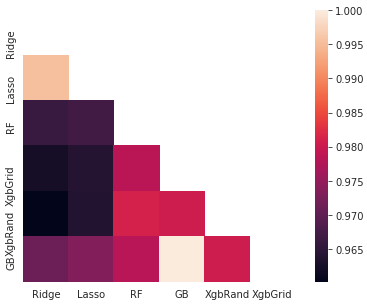

In [51]:
corr = results.iloc[:, 2: 8].corr().sort_values("GB", ascending=True)
plt.figure(figsize=(7, 5))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    ax = sns.heatmap(corr, mask=mask, square=True)
plt.show()

In [52]:
results['Ensembling'] = 0.80*results['GB'] + 0.1*results['XgbRand'] + 0.1*results['Lasso']

In [53]:
results

,y_valid,lm,Ridge,Lasso,RF,GB,XgbRand,XgbGrid,ElasticNet,Ensembling
968,37900.0,67359.433566,53497.811535,61027.822746,84023.720008,66303.920006,76304.820312,63095.320312,69730.514821,66776.400311
1281,180000.0,191035.232801,197998.139490,192853.872155,190247.941603,190400.428035,179028.406250,188678.968750,191127.441823,189508.570269
1053,144500.0,155474.853403,159838.840119,154760.802355,150268.745452,139482.981214,145377.593750,132011.281250,181252.865700,141600.224582
299,158500.0,146496.538972,138077.865849,150797.704944,138024.532175,158314.059783,163678.625000,149808.593750,128818.444276,158098.880821
134,180000.0,178921.194598,181065.155811,175866.000593,173178.369574,180930.181098,182473.875000,165192.484375,208959.861378,180578.132438
1423,274970.0,211717.950173,201681.647745,205137.332762,192601.079022,208993.591626,212484.375000,200364.093750,213335.116920,208957.044077
443,172500.0,206601.847895,200077.297124,195012.836395,198689.129155,197409.285208,200887.984375,194246.453125,175034.060761,197517.510243
1390,235000.0,225672.078259,232206.922641,225579.107617,230785.261508,227000.612829,233619.421875,223024.546875,239114.281586,227520.343212
1400,120000.0,113219.137554,124916.362753,128147.415266,114780.599284,129574.045347,128411.398438,124110.601562,109076.050702,129315.117648
1432,64500.0,68479.998706,62717.513620,71833.082974,102284.404680,96717.274675,98408.007812,96141.218750,84968.632534,94397.928818


#### Importance des variables

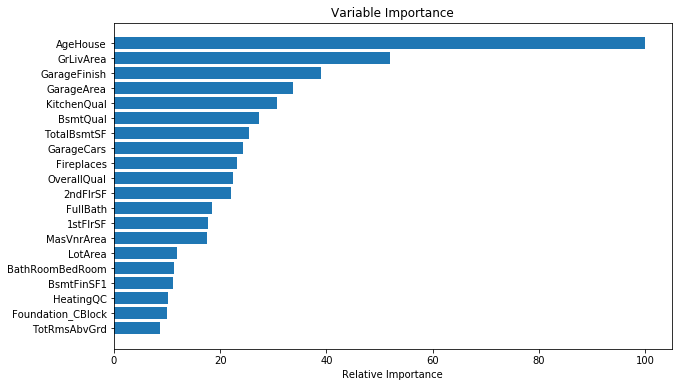

In [55]:
# Plot feature importance
top = 20
feature_importance = models['GB'].feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize = (10,6))
plt.barh(pos[-top:], feature_importance[sorted_idx][-top:], align='center')
plt.yticks(pos[-top:], df_copy.columns[sorted_idx][-top:])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Evaluation des performances des differents modèles :

In [60]:
# Mean Absolute Persentage Error
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Root Mean Squared Error
def rmse(y_pred, y_true):
    return np.sqrt(((y_pred - y_true) ** 2).mean())


# R2
def r2(y_pred, y_true):
    return r2_score(y_true, y_pred)

In [63]:
performance = [[rmse(results['y_valid'], results[x]), mape(results['y_valid'], results[x]), r2(results['y_valid'], results[x])] for x in results.columns[1:]]
performance = pd.DataFrame(performance, columns=['RMSE',
                                                 'MAPE', 'R2']).round(2)
performance['Estimateurs'] = list(results.columns[1:])
performance.sort_values('MAPE', ascending=True, inplace = True)
performance = performance[['Estimateurs', 'MAPE', 'RMSE', 'R2']]
performance['RMSE'] = list(performance.RMSE.astype('int'))
performance

,Estimateurs,MAPE,RMSE,R2
8,Ensembling,8.48,22900,0.90
4,GB,8.77,23105,0.90
6,XgbGrid,9.60,25374,0.89
5,XgbRand,9.61,26792,0.87
2,Lasso,9.66,26290,0.87
1,Ridge,10.13,26405,0.87
3,RF,10.54,27421,0.85
0,lm,11.00,27624,0.86
7,ElasticNet,17.20,40383,0.63


#### Sauvegarde du meilleur modèle :

In [64]:
# Sauvegarder le modèle sur le disque :
pickle.dump(models, open('models/model.pkl', 'wb'))

#### Prédiction des prix avec le meilleur modèle

In [67]:
# dataframe  des données de soumissions
soumission = pd.DataFrame({'Id': [i+1 for i in df.index.tolist() if i not in train_index]})

# Prédicition du prix
results = pd.DataFrame({'GB': models['GB'].predict(df_test),
                        'XgbRand': models['XgbRand'].predict(df_test),
                        'Lasso': models['Lasso'].predict(df_test)})

soumission['SalePrice'] = 0.70*results['GB'] + 0.2*results['XgbRand'] + 0.1*results['Lasso']
# soumission['SalePrice'] = 0.80*results['GB'] + 0.1*results['XgbRand'] + 0.1*results['Lasso']
soumission['SalePrice'] = soumission.SalePrice.astype('int')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


In [68]:
#soumission.head()
soumission.to_csv('data/submission_ensembling.csv', index=False)

#### Conclusion :